In [1]:
import sys
!conda install -y pytorch torchvision torchaudio cpuonly -c pytorch

Channels:
 - pytorch
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\troit\anaconda3

  added / updated specs:
    - cpuonly
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.11.12 |       h4c7d964_0         149 KB  conda-forge
    certifi-2025.11.12         |     pyhd8ed1ab_0         153 KB  conda-forge
    cpuonly-2.0                |                0           2 KB  pytorch
    libjpeg-turbo-2.1.4        |       hcfcfb64_0         1.3 MB  conda-forge
    libuv-1.51.0               |       hfd05255_1         290 KB  conda-forge
    libwebp-1.3.2              |       hcfcfb64_1          69 KB  conda-forge
    pytorch-2.5.1              |     py3.11_cpu_0       151.3 MB  pytorch
    pytorch-mutex-1.0          |              cpu   

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2)),
])

batch_size = 125

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('самолет', 'автомобиль', 'птица', 'кот', 'олень', 
           'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик')

Используемое устройство: cpu
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

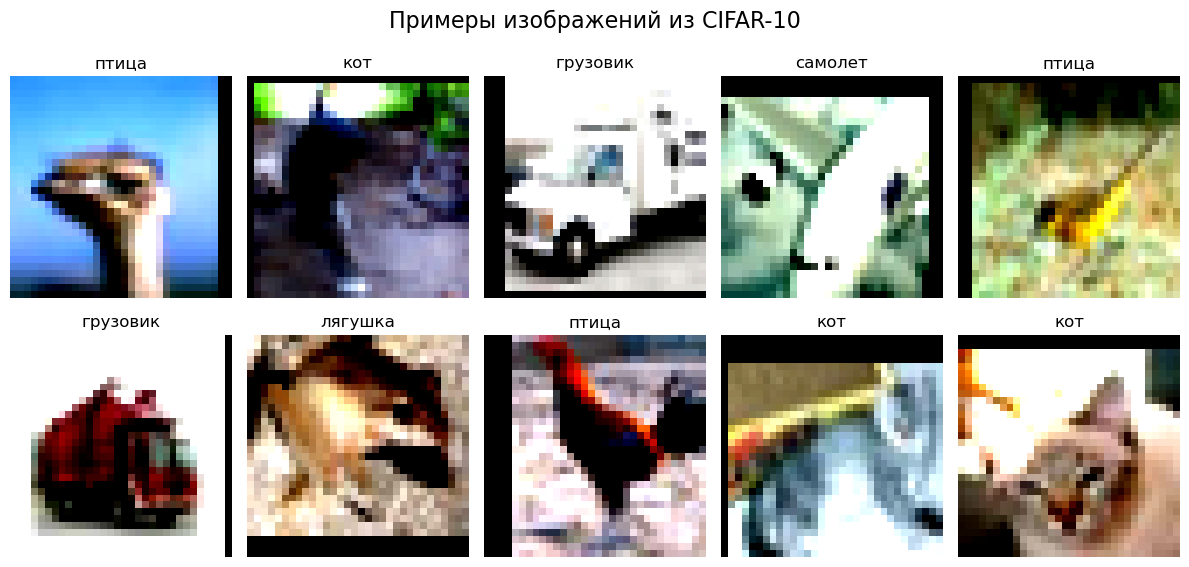

Размерность одного изображения: torch.Size([3, 32, 32])
Размер батча: torch.Size([125, 3, 32, 32])
Количество классов: 10
Размер тренировочного набора: 50000
Размер тестового набора: 10000


In [9]:

def imshow(img, ax=None):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    
    if ax is None:
        plt.imshow(npimg)
        plt.axis('off')
    else:
        ax.imshow(npimg)
        ax.axis('off')

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Примеры изображений из CIFAR-10', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    imshow(images[i], ax)  # Передаем ax в функцию
    ax.set_title(f'{classes[labels[i]]}')

plt.tight_layout()
plt.show()

print(f"Размерность одного изображения: {images[0].shape}")
print(f"Размер батча: {images.shape}")
print(f"Количество классов: {len(classes)}")
print(f"Размер тренировочного набора: {len(trainset)}")
print(f"Размер тестового набора: {len(testset)}")

In [11]:
class CustomCNN(nn.Module):

    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x

model = CustomCNN(num_classes=len(classes)).to(device)

'''total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")'''

'total_params = sum(p.numel() for p in model.parameters())\ntrainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)\nprint(f"Всего параметров: {total_params:,}")\nprint(f"Обучаемых параметров: {trainable_params:,}")'

In [12]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)
num_epochs = 6

C:\Users\troit\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:

def train_epoch(model, trainloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 99:
            print(f'Эпоха: {epoch+1}, Батч: {batch_idx+1}, '
                  f'Потеря: {running_loss/(batch_idx+1):.4f}, '
                  f'Точность: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = running_loss / len(testloader)
    test_acc = 100. * correct / total
    return test_loss, test_acc


train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Начало обучения...")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nЭпоха {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    test_loss, test_acc = validate(model, testloader, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    scheduler.step(test_loss)
    
    print(f"Итоги эпохи {epoch+1}:")
    print(f"Тренировочные - Потеря: {train_loss:.4f}, Точность: {train_acc:.2f}%")
    print(f"Тестовые - Потеря: {test_loss:.4f}, Точность: {test_acc:.2f}%")
    
    if test_acc == max(test_accuracies):
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Модель сохранена (лучшая точность: {test_acc:.2f}%)")

total_time = time.time() - start_time
print(f"\nОбучение завершено за {total_time:.2f} секунд")

Начало обучения...

Эпоха 1/6
--------------------------------------------------
Эпоха: 1, Батч: 100, Потеря: 1.8345, Точность: 28.81%
Эпоха: 1, Батч: 200, Потеря: 1.6838, Точность: 35.60%
Эпоха: 1, Батч: 300, Потеря: 1.5850, Точность: 39.93%
Эпоха: 1, Батч: 400, Потеря: 1.5112, Точность: 43.24%
Итоги эпохи 1:
Тренировочные - Потеря: 1.5112, Точность: 43.24%
Тестовые - Потеря: 1.2627, Точность: 54.56%
Модель сохранена (лучшая точность: 54.56%)

Эпоха 2/6
--------------------------------------------------
Эпоха: 2, Батч: 100, Потеря: 1.1639, Точность: 57.86%
Эпоха: 2, Батч: 200, Потеря: 1.1325, Точность: 59.05%
Эпоха: 2, Батч: 300, Потеря: 1.0970, Точность: 60.49%
Эпоха: 2, Батч: 400, Потеря: 1.0711, Точность: 61.53%
Итоги эпохи 2:
Тренировочные - Потеря: 1.0711, Точность: 61.53%
Тестовые - Потеря: 0.8872, Точность: 67.82%
Модель сохранена (лучшая точность: 67.82%)

Эпоха 3/6
--------------------------------------------------
Эпоха: 3, Батч: 100, Потеря: 0.9395, Точность: 66.96%
Эпоха: 